In [1]:
using MyBioTools, MyBioTools.FluTools, TreeTools
using StatsBase, Dates, LaTeXStrings, Statistics
using BioSequences, FastaIO
using CurveFit
using Plots
pyplot()

┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/MyBioTools.ji for MyBioTools [top-level]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

In [2]:
sp = FluTools.StrainPop("../data/aligned_h3n2_ha.fasta", missingdates = false, seqtype=:nt, segment="ha", strain="h3n2");
FluTools.bin_by_date!(sp, start=Date(2001), binwidth=Day(15), binspacing=Day(30));

Translating sequences...
Reading alignment...


In [3]:
# History of all positions
L = length(sp.strains[1].aa_seq)
ph = Array{FluTools.PosEvo,1}(undef,L)
for i in 1:L
    print("$i       \r")
    ph[i] = FluTools.positions_history(i, sp)
end

In [86]:
# Rising trajectories
all_traj = FluTools.all_trajectories(ph);
all_traj = FluTools.previous_state_condition(all_traj, :lost);
all_traj = FluTools.population_size_condition(all_traj, 10);


In [115]:
# Read tree
tree = read_tree("../data/tree_building_ha_100permonth/tree_refined.nwk")
# Read mutations 
FluTools.read_mutations!(tree, "../data/tree_building_ha_100permonth/aa_muts.json", type=:aa, lineage=:"h3n2", segment="ha")
# Quantify their spread in the tree
for traj in all_traj
    FluTools.find_strains!(traj, sp)
    FluTools.compute_tree_spread!(traj, tree)
end

NODE_0017638
NODE_0017638
NODE_0017638


- Look at small frequency bins --> $d\alpha$ = 0.05
- Look at how trajectories were spread in the tree when they *entered* the bin
- See if this has any impact on their fixation/loss probabilities

In [188]:
# Frequency bins
dα = 0.05
alphabins = [(α, dα) for α in 0.2:0.1:0.8];
alphavalues = [x[1] for x in alphabins];

In [189]:
# Trajectories for each frequency bin
freqtraj_cf = Dict()
for (α, dα) in alphabins
    freqtraj_cf[α] = FluTools.frequency_condition(all_traj, α, dα=dα, shift_time=true)
end

In [190]:
# Trajectories that are relatively spread in the tree (score > 0.2)
function find_spread_trajectories(traj_array; threshold=0.2, score=:squaredfreqs)
    return traj_array[findall(x->!ismissing(x) && x >threshold ,[FluTools.treespread_score(traj, scoretype=score)[traj.index[:active]] for traj in traj_array])]
end
spread_traj = Dict()
for α in alphavalues
    spread_traj[α] = find_spread_trajectories(freqtraj_cf[α], threshold=0.1, score=:squaredfreqs)
end

In [191]:
pfix_all = [count(x->x.fixation==:fixed, freqtraj_cf[α])/length(freqtraj_cf[α]) for α in alphavalues];
pfix_spread = [count(x->x.fixation==:fixed, spread_traj[α]) / length(spread_traj[α]) for α in alphavalues];

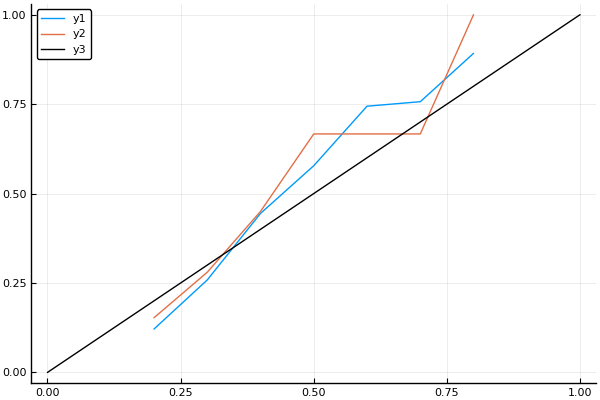

In [192]:
plot(alphavalues, pfix_all)
plot!(alphavalues, pfix_spread)
plot!([0,1],[0,1], color=:black)

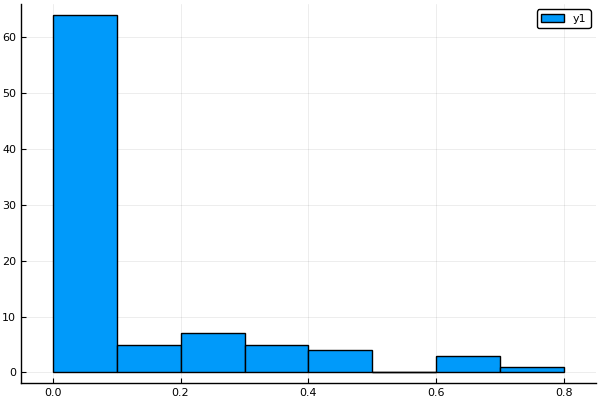

In [169]:
histogram([FluTools.treespread_score(traj, scoretype=:squaredfreqs)[traj.index[:active]] for traj in freqtraj_cf[0.3]])

In [182]:
freqtraj_cf[0.3][49].date .+ freqtraj_cf[0.3][49].t

8-element Array{Date,1}:
 2008-03-10
 2008-04-09
 2008-05-09
 2008-06-08
 2008-07-08
 2008-08-07
 2008-09-06
 2008-10-06

In [170]:
findmax(collect(skipmissing([FluTools.treespread_score(traj)[traj.index[:active]] for traj in freqtraj_cf[0.3]])))

(0.7109375, 49)

In [138]:
α

0.55

In [177]:
FluTools.treespread_squaredfreqs(freqtraj_cf[0.3][49].treespread)

8-element Array{Union{Missing, Float64},1}:
  missing           
 0.513888888888889  
 0.6115702479338844 
 0.5800000000000001 
 0.6044444444444443 
 0.7109375          
 0.24970273483947691
 0.5                

In [195]:
map(x->x.fixation==:fixed && println(x.i), freqtraj_cf[0.2]);

19
41
49
61
64
66
91
99
156
160
161
171
175
175
189
205
209
218
228
238
241
241
242
243
294
328
377
505
